In [209]:
from data.dataset import ICDR2015Dataset
from models.model import DBNet
import matplotlib.pyplot as plt
import torch
from torch.nn import BCELoss, L1Loss
from data.dataloader import get_loaders
import cv2 as cv
from data.process.utils import resize_image
from tqdm import tqdm
import numpy as np
from shapely.geometry import Polygon
import pyclipper

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
train_loader, val_loader = get_loaders('data', batch_size=1)

bin_loss_fn = BCELoss()
prob_loss_fn = BCELoss()
thresh_loss_fn = L1Loss()


def db_loss(pred, gt, train=True):
    if train:
        bin_loss = bin_loss_fn(pred["bin_map"], gt["bin_map"])
        print('bin -', bin_loss.item())
        prob_loss = prob_loss_fn(pred["prob_map"], gt["bin_map"])
        print('prob -', prob_loss.item())
        thresh_loss = thresh_loss_fn(pred["thresh_map"], gt["thresh_map"])
        print('thresh -', thresh_loss.item())
        loss = prob_loss + bin_loss + 10 * thresh_loss
        print('total -', loss.item())
    else:
        loss = 0
    return loss

In [211]:
def get_avg_bin_loss(model, loader):
    running_loss = 0.0
    dataset_size = 0

    for img, maps in tqdm(loader):
        batch_size = img.shape[0]

        img = img.permute(0, 3, 1, 2)
        img = img.to(device='cuda', dtype=torch.float32)
        img = (img - img.mean()) / img.std()
        output = model(img)['bin_map']

        bin_map = maps['bin_map'].to(device='cuda', dtype=torch.float32)
        bin_loss = bin_loss_fn(output, bin_map)

        running_loss += batch_size * bin_loss.item()
        dataset_size += batch_size
    return running_loss / dataset_size

[Epoch 279]
bin - 0.004186827223747969
prob - 0.0012859143316745758
thresh - 0.005343075841665268
total - 0.05890350043773651


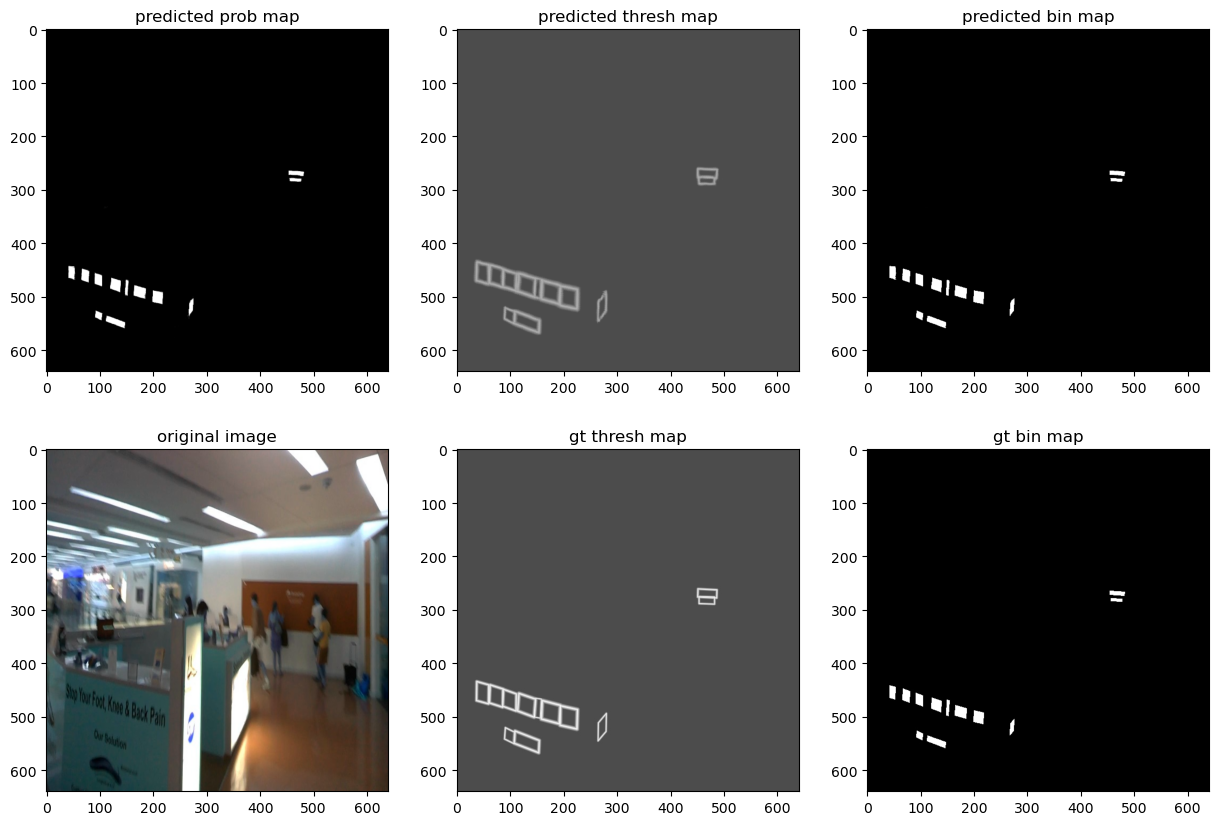

In [227]:
model = DBNet().cuda()
checkpoint = torch.load('models/checkpoints/dbnet_061', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f'[Epoch {checkpoint['epoch']}]')

img, maps = next(iter(val_loader))
img = img[0].permute(2, 0, 1).unsqueeze(0)
img = img.to(device='cuda', dtype=torch.float32)
img = (img - img.mean()) / img.std()
output = model(img)

for k, v in maps.items():
    maps[k] = v.to(device='cuda', dtype=torch.float32)
db_loss(output, maps)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0][0].imshow(output['prob_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[0][0].set_title('predicted prob map')
axs[0][1].imshow(output['thresh_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[0][1].set_title('predicted thresh map')
axs[0][2].imshow(output['bin_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[0][2].set_title('predicted bin map')

axs[1][0].imshow(((img - img.min()) / (img.max() - img.min()))[0].permute(1, 2, 0).detach().cpu())
axs[1][0].set_title('original image')
axs[1][1].imshow(maps['thresh_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[1][1].set_title('gt thresh map')
axs[1][2].imshow(maps['bin_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[1][2].set_title('gt bin map')
plt.show()

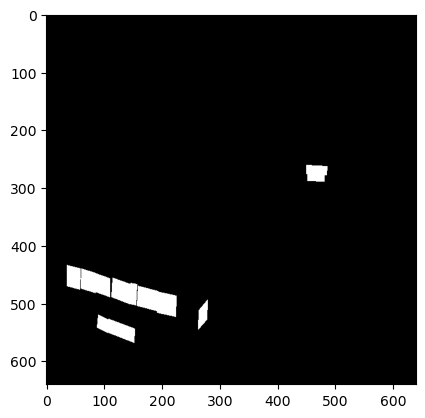

In [228]:
plt.imshow(maps['gt_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')

In [229]:
prob_map = output['prob_map']
prob_map = prob_map.detach().cpu().numpy().squeeze()
bin_map = (prob_map >= 0.2).astype(np.uint8)
contours, _ = cv.findContours(bin_map, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

polygons = []
for cnt in contours:
    area = cv.contourArea(cnt)
    if area < 50: continue
    approx = cv.approxPolyDP(cnt, 0.01 * cv.arcLength(cnt, True), True)
    polygons.append(approx.reshape(-1, 2))

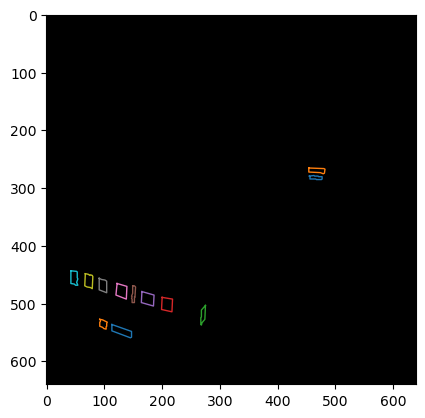

In [230]:
plt.imshow(np.zeros((640, 640)), cmap='gray')
for poly in polygons:
    Gs = Polygon(poly)
    plt.plot(*Gs.exterior.xy, linewidth=1)
plt.show()

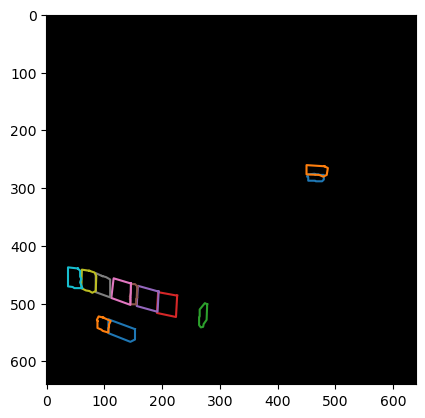

In [231]:
plt.imshow(np.zeros((640, 640)), cmap='gray')
for poly in polygons:
    Gs = Polygon(poly)
    D = Gs.area * 1.5 / Gs.length
    pco = pyclipper.PyclipperOffset()
    pco.AddPath(poly, pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
    G = Polygon(pco.Execute(D)[0])
    plt.plot(*G.exterior.xy)
plt.show()

In [235]:
avg_train_loss = get_avg_bin_loss(model, train_loader)
avg_val_loss = get_avg_bin_loss(model, val_loader)
avg_train_loss, avg_val_loss

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:04<00:00, 72.76it/s]


(0.006319787333098551, 0.03176071441111465)

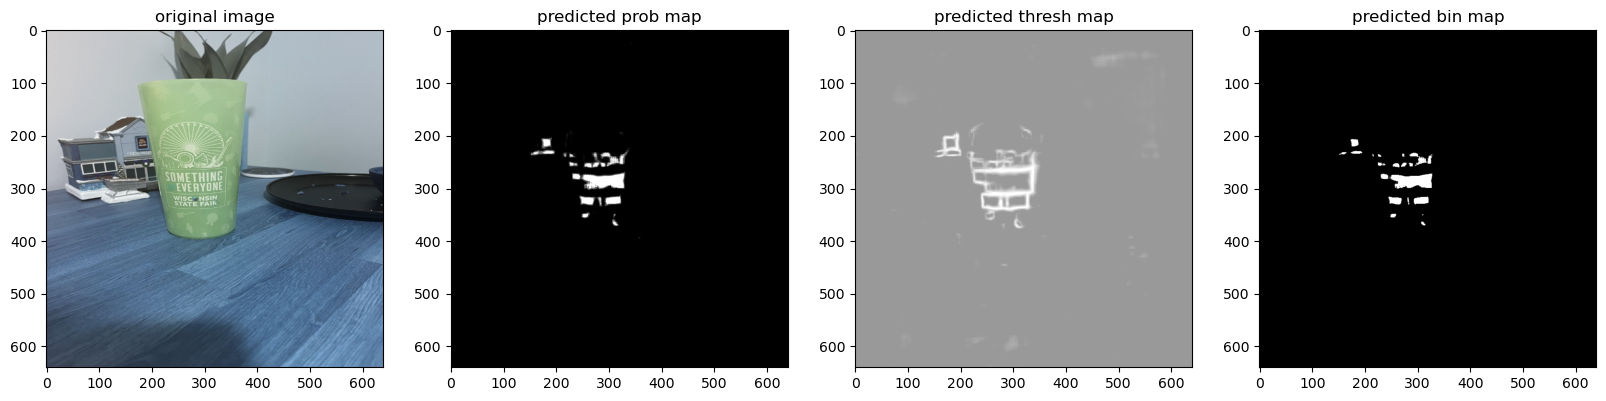

In [24]:
img = cv.imread('../rsz_image.jpg', cv.IMREAD_UNCHANGED) / 255
img = resize_image(img)
img = torch.from_numpy(img)
img = img.to(device='cuda', dtype=torch.float32)
output = model(img.permute(2, 0, 1).unsqueeze(0))

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

axs[0].imshow(((img - img.min()) / (img.max() - img.min())).detach().cpu())
axs[0].set_title('original image')
axs[1].imshow(output['prob_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[1].set_title('predicted prob map')
axs[2].imshow(output['thresh_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[2].set_title('predicted thresh map')
axs[3].imshow(output['bin_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[3].set_title('predicted bin map')
plt.show()